# Synthetic data test: Model with multiple sources and moving window scheme

This test is meant to represent a scenario closer to the real data. We'll add multiple sources to the region and run the Euler inversion on a moving window scheme.

In [1]:
from pathlib import Path
import warnings
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

In [2]:
warnings.filterwarnings("ignore")

## Make a model with multiple sources

Establish the model region, data grid coordinates, magnetization, etc. Then add different sources to the model by superposition.

In [93]:
region = [0, 80e3, 0, 70e3]
spacing = 500
height = 1000
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=height)
inclination, declination = -30, -10
base_level = 1000
noise_level = 50
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipoles
dipole_coordinates = (30e3, 15e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
dipole2_coordinates = (35e3, 20e3, -500)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(1e11, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Pipe
size = 50
pipe_coordinates = (60e3, 50e3, 500)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        pipe_coordinates[0] - size,
        pipe_coordinates[0] + size,
        pipe_coordinates[1] - size,
        pipe_coordinates[1] + size,
        pipe_coordinates[2] - 15e3,
        pipe_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(1000, -90, 0),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Dikes
dike_coordinates_h = (10e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates_h[0] - 100e3,
        dike_coordinates_h[0] + 100e3,
        dike_coordinates_h[1] - 100,
        dike_coordinates_h[1] + 100,
        dike_coordinates_h[2] - 7e3,
        dike_coordinates_h[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(20, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
dike_coordinates_v = (20e3, 45e3, 800)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates_v[0] - 100,
        dike_coordinates_v[0] + 100,
        dike_coordinates_v[1] - 100e3,
        dike_coordinates_v[1] + 100e3,
        dike_coordinates_v[2] - 6e3,
        dike_coordinates_v[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(50, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        line_coordinates[0] - 50,
        line_coordinates[0] + 50,
        line_coordinates[1],
        line_coordinates[1] + 100e3,
        line_coordinates[2] - 50,
        line_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(3000, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Sill
sill_coordinates = [60e3, 25e3, -0.5e3]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        sill_coordinates[0] - 10e3,
        sill_coordinates[0] + 10e3,
        sill_coordinates[1] - 15e3,
        sill_coordinates[1] + 15e3,
        sill_coordinates[2] - 100,
        sill_coordinates[2] + 100,
    ],
    magnetization=hm.magnetic_angles_to_vec(100, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

Now add a polynomial regional field, some random noise, and a base level.

In [94]:
# Regional
regional_angular_e = 0.02
regional_angular_n = -0.03
magnetic_anomaly += regional_angular_e * coordinates[0] + regional_angular_n * coordinates[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

Number of data: 22701


Now make the data into an `xarray` grid and calculate derivatives using finite-differences (for horizontal) and FFT (for vertical).

In [95]:
# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

data

<xarray.Dataset> Size: 910kB
Dimensions:      (northing: 141, easting: 161)
Coordinates:
    height       (northing, easting) float64 182kB 1e+03 1e+03 ... 1e+03 1e+03
  * easting      (easting) float64 1kB 0.0 500.0 1e+03 ... 7.95e+04 8e+04
  * northing     (northing) float64 1kB 0.0 500.0 1e+03 ... 6.95e+04 7e+04
Data variables:
    field        (northing, easting) float64 182kB 1.002e+03 944.6 ... 392.6
    deriv_east   (northing, easting) float64 182kB -0.1153 0.0414 ... -0.02587
    deriv_north  (northing, easting) float64 182kB -0.1333 0.2865 ... -0.1105
    deriv_up     (northing, easting) float64 182kB -0.2773 0.1881 ... 0.1169

Plot the data and derivatives to make sure it looks OK.

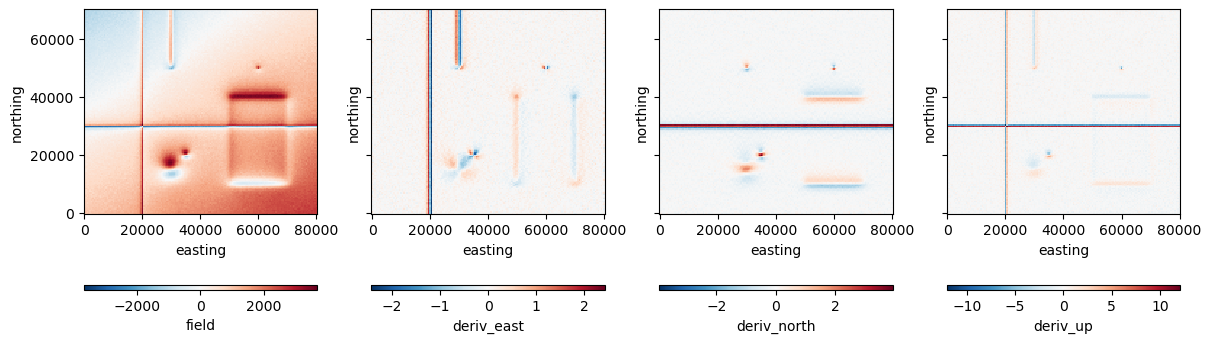

In [96]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

## Run Euler Deconvolution and Inversion

Now run Euler inversion (with weights), Euler deconvolution, and finite-difference Euler deconvolution on a moving window scheme with the same window parameters.

In [98]:
window_size = 7e3
window_step = window_size / 4

Euler deconvolution is run 3 times, once for each SI.

In [99]:
%%time
deconvolutions = {}
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.15,
    ).fit_grid(data)

CPU times: user 11.6 s, sys: 12.2 ms, total: 11.6 s
Wall time: 11.6 s


Finite-difference Euler deconvolution is run only once and the SI is estimated.

In [100]:
%%time
fd = euler.EulerDeconvolutionFDWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.15,
).fit_grid(data)

CPU times: user 3.18 s, sys: 79 μs, total: 3.18 s
Wall time: 3.18 s


Euler inversion is run only once and the SI is estimated.

In [101]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.15,
).fit_grid(data)

CPU times: user 966 ms, sys: 240 ms, total: 1.21 s
Wall time: 12.2 s


## Make a figure for the paper

Prepare a figure with the synthetic data and the results from Euler deconvolution and inversion.

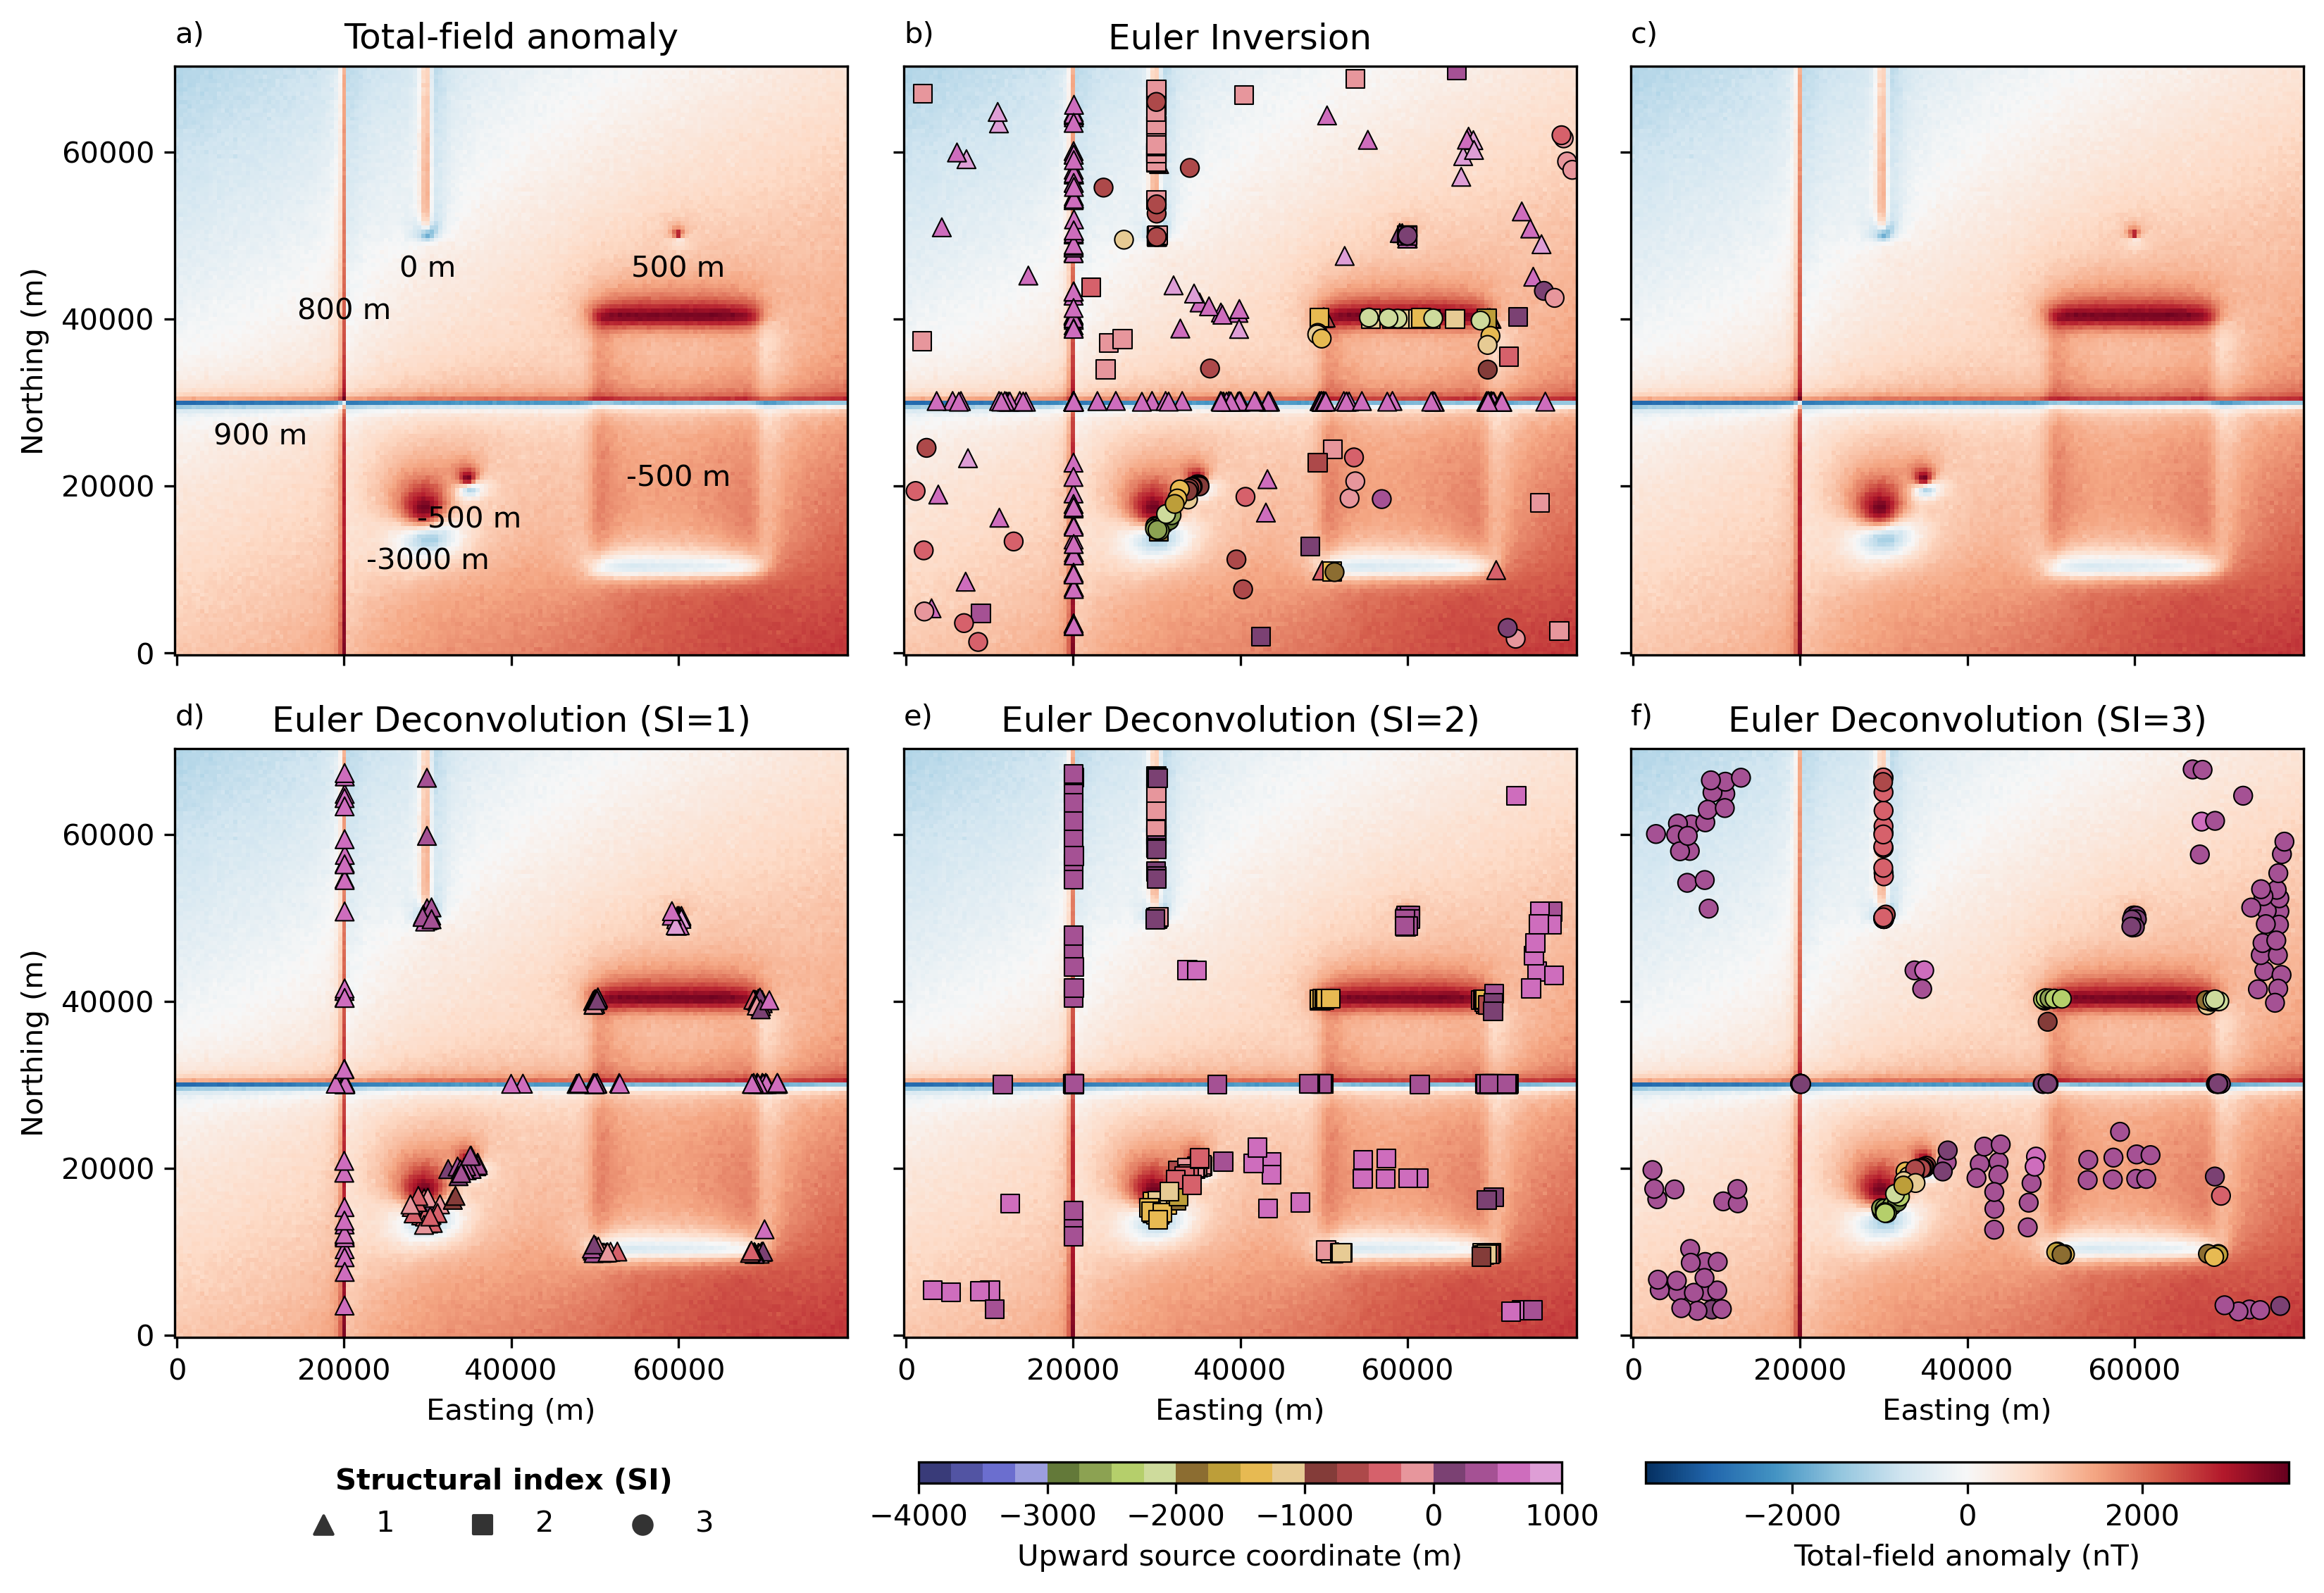

In [102]:
fig, axes = plt.subplots(
    2, 3, figsize=(11, 7.5), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdef"]
markers = ["^", "s", "o"]
vmin, vmax = -4000, 1000
size = 40
linewidth = 0.5
true_sources = [
    dipole_coordinates,
    dipole2_coordinates,
    dike_coordinates_h,
    dike_coordinates_v,
    sill_coordinates,
    pipe_coordinates,
    line_coordinates,
]
for ax in axes.ravel():
    ax.set_aspect("equal")
    data_plot = data.field.plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False)

ax = axes[0, 0]
ax.set_title("Total-field anomaly")
for source in true_sources:
    ax.text(
        source[0], source[1] - 5e3, f"{source[2]:.0f} m", horizontalalignment="center"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=linewidth,
        cmap="tab20b",
    )

# Finite 
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=linewidth,
        cmap="tab20b",
    )

# Euler inversion
labels = {}
ax = axes[0, 1]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    depth_plot = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=linewidth,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)


fig.colorbar(
    depth_plot,
    ax=axes[1, 1],
    aspect=30,
    pad=0.05,
    shrink=0.9,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
fig.colorbar(
    data_plot,
    ax=axes[1, 2],
    aspect=30,
    pad=0.05,
    shrink=0.9,
    orientation="horizontal",
    label="Total-field anomaly (nT)",
)
fig.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    ncols=3,
    title="Structural index (SI)",
    loc="lower left",
    bbox_to_anchor=[0.115, 0.015],
    title_fontproperties=dict(weight="bold"),
)

for ax, label in zip(axes.ravel(), subplot_labels):
    ax.text(0, 1.04, label, transform=ax.transAxes)
for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_yticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")

fig.get_layout_engine().set(w_pad=0, h_pad=0.1, hspace=0, wspace=0)

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-windows.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)